## Environment

In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1


import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(os.getcwd(), os.pardir,os.pardir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)


import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns
sns.set()

import statsmodels.api as sm
from scipy.stats import chisquare

from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error as MSE
from sklearn.metrics import precision_recall_fscore_support as report
from sklearn.preprocessing import StandardScaler

import helpers as hlp
%aimport helpers
import settings
from data.preprocessing import load_file,save_file,filter_by_season,get_scaled_series,display_df
%aimport data.preprocessing
from features import tools
%aimport features.tools

pd.options.display.max_rows = 10

from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

row_headers=["Product"]

## Feature Engineering

In [2]:
p1cc = load_file("p1cc",index="Product")

p1cc.head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16
Product,,,,,,,,,,,,,,,,
3.6E+101_2,1.0,3.0,5.0,4.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
30E000400_2,55.0,222.0,261.0,275.0,279.0,265.0,298.0,230.0,193.0,154.0,118.0,72.0,56.0,35.0,25.0,22.0
30E823101_2,3.0,15.0,18.0,30.0,30.0,40.0,31.0,48.0,33.0,44.0,36.0,32.0,34.0,25.0,26.0,3.0
30E823102_2,8.0,26.0,32.0,33.0,41.0,38.0,51.0,38.0,54.0,47.0,45.0,39.0,37.0,36.0,8.0,26.0
30E823103_2,3.0,15.0,33.0,40.0,36.0,47.0,38.0,53.0,50.0,56.0,45.0,46.0,38.0,34.0,36.0,3.0


In [9]:
! python c:/Users/rahmim00/Documents/Notebooks/Clustering/pc_clustering/src/features/build_features.py

2018-08-02 10:57:42,972 - __main__ - INFO - *** Build features for classification and prediction models ***
2018-08-02 10:57:42,972 - __main__ - INFO - Load raw sales file...
2018-08-02 10:57:43,004 - __main__ - INFO - Load product description file...
2018-08-02 10:57:43,442 - __main__ - INFO - Load clients count  file...
2018-08-02 10:57:43,447 - __main__ - INFO - Load number of clients by week...
2018-08-02 10:57:43,479 - __main__ - INFO - Feature engineering...
2018-08-02 10:57:43,729 - __main__ - INFO - ==> Saving features file to clf_features ...
2018-08-02 10:57:43,776 - __main__ - INFO - Dataset  6815  succefully made !
2018-08-02 10:57:43,776 - __main__ - INFO - Creating encoders...


In [82]:
s = "Autumn"
v = 1
clustering_model = "nb_p2_clusters_%s"%(s)
# clustering_model = "p2_clusters_Autumn_v99"

#Load files
raw_df = load_file("p2_raw").set_index(row_headers)
series_df =load_file("p2_series",type_="P",version = 1).set_index(row_headers)
clean_df = load_file("p2_clean",type_="P",version = 1).set_index(row_headers)

#Filter and normalize
sclean_df = filter_by_season(clean_df,s)
zclean_df,_ =  get_scaled_series(sclean_df)

#clustering result
cluster_df = load_file(clustering_model,index=row_headers,type_="M",version = v)

#cleaned features
features_df = load_file('clf_features',type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))

numeric = (list(features_df.columns.to_series().groupby(features_df.dtypes).groups[np.dtype('float64')]))
features_list = list(features_df.columns) + ["Cluster"]
df = features_df.join(cluster_df,how="inner")[features_list]


print(df.shape)
df.head(2)

set(df.Cluster.value_counts().index)

(1046, 17)


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

## Classification Models

In [83]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder
from sklearn.tree import  export_graphviz
import subprocess

drop=["Color","Size","Ptype","Sales Season"]
drop = []
features_df = df[features_list].drop(drop,axis=1).copy()
data = features_df.drop_duplicates().copy()
# data["Sales Season"] = s

# data = pd.concat([data, clean_df.loc[data.index,['1','2','3'] ]], axis = 1)
print(data.shape)
display(data.head())

(1046, 17)


,Color,Size,Ldate,Age Group,Person,Pname,Ptype,Tprice,Currency,Sales Season,Nstore,s1,s2,s3,s4,s5,Cluster
Product,,,,,,,,,,,,,,,,,
3.6E+101_2,Other,Thick,36,29-38,Pregnant,One-Piece Pants,Thin,49.0,Y,Autumn,6.0,1.0,3.0,5.0,4.0,3.0,7
31C000963_2,Black,Sheer,40,29-38,Female,One-Piece Pants Inside,Thin,29.0,$,Autumn,337.0,98.0,242.0,188.0,198.0,156.0,7
31C002201_2,Grey,No Size,36,18-28,Female,One-Piece Pants Inside,Thin,29.0,$,Autumn,27.0,3.0,9.0,15.0,23.0,23.0,4
31C002300_2,Black,Sheer,43,29-38,Female,One-Piece Pants Inside,Thin,29.0,$,Autumn,340.0,83.0,201.0,176.0,139.0,108.0,7
31C002400_2,Black,Sheer,37,29-38,Female,One-Piece Pants Inside,Thin,39.0,$,Autumn,344.0,9.0,65.0,133.0,165.0,145.0,4


### Grid Search

### Load trained model

(5, 165)


,Ldate_1,Ldate_10,Ldate_11,Ldate_12,Ldate_13,Ldate_14,Ldate_15,Ldate_16,Ldate_17,Ldate_18,...,Age Group_39-48,Age Group_4-6,Age Group_7-9,Tprice,Nstore,s1,s2,s3,s4,s5
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.324324,0.007375,0.000000,0.003891,0.005181,0.002837,0.001767
31C000963_2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.189189,0.495575,0.167530,0.313878,0.194819,0.140426,0.091873
31C002201_2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.189189,0.038348,0.003454,0.011673,0.015544,0.016312,0.013545
31C002300_2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.189189,0.500000,0.141623,0.260700,0.182383,0.098582,0.063604
31C002400_2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.256757,0.505900,0.013817,0.084306,0.137824,0.117021,0.085395


Train

avg / total       0.93      0.92      0.92       784

Test

avg / total       0.52      0.51      0.50       262



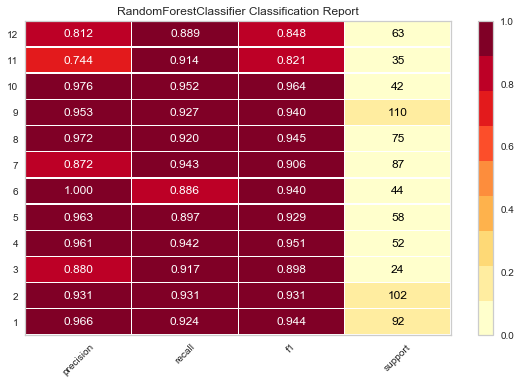

In [108]:
from models.predict_model_classifier import load_model as clf_load,  train_model as clf_train,  predict as clf_predict, preprocess as clf_preprocess
%aimport models.predict_model_classifier

classifier = clf_load("classifier_Autumn")

X,y  = clf_preprocess(data.drop("Cluster", axis=1), data.Cluster)
feature_labels = X.columns
display_df(X.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=None) 
classifier.model = RandomForestClassifier(n_estimators=60,max_depth=8,min_samples_split=2, min_samples_leaf=1, criterion='gini', max_features=None, bootstrap=True)
classifier.model.fit(X_train, y_train)



y_pred= classifier.model.predict(X_test)
yt_pred= classifier.model.predict(X_train)

print("Train")
print(classification_report(y_train,yt_pred,labels=np.unique(y_train) )[-54*1:])
print("Test")
print(classification_report(y_test,y_pred,labels=np.unique(y_test) )[-54*1:])

visualizer = ClassificationReport(classifier.model, classes=None, support=True)
visualizer.score(X_train, y_train)  # Evaluate the model on the test data
g = visualizer.poof()

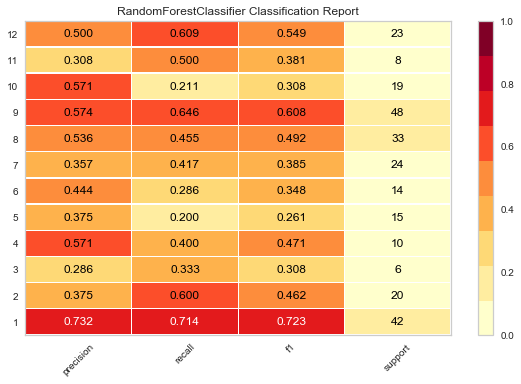

In [109]:
visualizer = ClassificationReport(classifier.model, classes=None, support=True)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

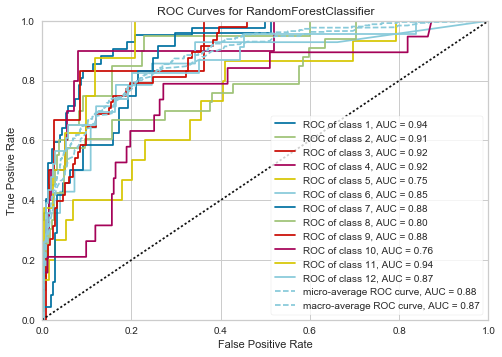

In [112]:
from yellowbrick.classifier import ROCAUC

# Instantiate the classification model and visualizer
visualizer = ROCAUC(classifier.model,classes = np.arange(12)+1)

visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

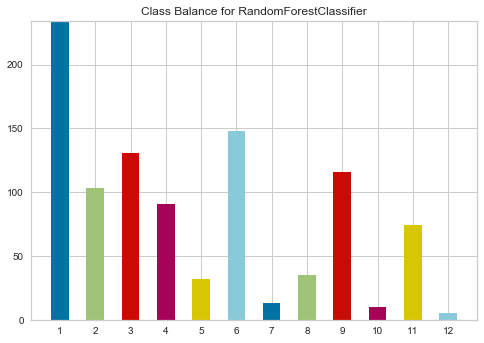

C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
from yellowbrick.classifier import ClassificationReport, ClassBalance
from yellowbrick.features.importances import FeatureImportances

visualizer = ClassBalance(classifier.model, classes=None)

visualizer.score(X,y)
# t = visualizer.poof() 
visualizer.score(X_train, y_train)  # Fit the training data to the visualizer
r = visualizer.poof() 
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# ts = visualizer.poof() 

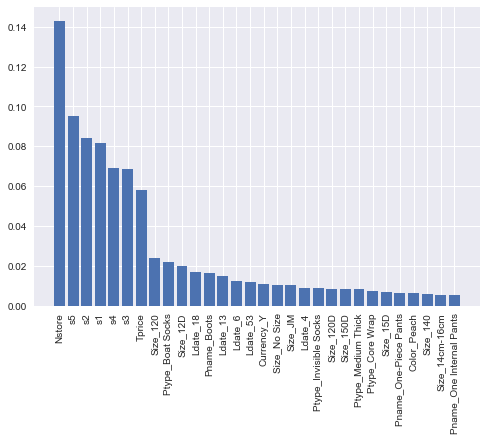

In [138]:
fi = classifier.model.feature_importances_
sorted_indices = np.argsort(fi)[::-1]

imp = sorted_indices[:30]

plt.bar(range(len(imp)),fi[imp])
plt.xticks(range(len(imp)), feature_labels[imp],rotation = 90)
plt.show()

In [201]:
# ldf, le, ohe = tools.create_encoder(data.drop(["Cluster"],axis=1), non_categorical = ["Tprice","Nstore"])
X = tools.encode(data.drop(["Cluster"],axis=1))
feature_labels = X.columns
y = data["Cluster"].copy()
print(X.shape)

series = clean_df.iloc[:,:3].copy()
series = series.apply(lambda x:x / x.std())


X.head(3)
# np.random.shuffle(y)

(1020, 160)


,Color_Black,Color_Blue,Color_Brown,Color_Green,Color_Grey,Color_Light Yellow,Color_Natural,Color_Orange,Color_Other,Color_Peach,...,Ptype_Stockings,Ptype_Thick,Ptype_Thicker,Ptype_Thin,Ptype_Tights,Ptype_Tube Socks,Ptype_Velvet,Ptype_Wool Socks,Tprice,Nstore
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.324324,0.007375
31C000963_2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.189189,0.495575
31C002201_2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.189189,0.038348


## Standard evaluation metrics of the algorithm

In [496]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE


classifier = RandomForestClassifier(n_estimators=120,max_depth=18,min_samples_split=2, min_samples_leaf=3, criterion='entropy', bootstrap=True)

# classifier  = RFE(classifier, 10, step=1)

# scores = cross_val_score(classifier, X, y, cv=2, scoring='f1_macro')
# print(scores,scores.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)
yt_pred = classifier.predict(X_train)

print("Train")
print(classification_report(y_train,yt_pred,labels=np.unique(y_test) )[-54*1:])
print("Test")
print(classification_report(y_test,y_pred,labels=np.unique(y_test) )[-54*1:])

Train

avg / total       0.63      0.61      0.60       814

Test

avg / total       0.35      0.36      0.35       204



C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
from yellowbrick.classifier import ClassificationReport, ClassBalance
from yellowbrick.features.importances import FeatureImportances

visualizer = ClassBalance(classifier, classes=None)

visualizer.score(X,y)
# t = visualizer.poof() 
visualizer.score(X_train, y_train)  # Fit the training data to the visualizer
r = visualizer.poof() 
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# ts = visualizer.poof() 

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)  
visualizer = ClassificationReport(classifier, classes=None, support=True)

visualizer.score(X_train, y_train)  # Fit the visualizer and the model
g = visualizer.poof()

In [ ]:
visualizer = ClassificationReport(classifier, classes=None, support=True)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

## RMSE to the center of the predicted cluster 
#### Joining the series with the predicted clusters of the test set

In [224]:
argsorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
nguess = argsorted[:,0:4]+1

series_df = raw_df.copy()
predictions = nguess
n_pred = predictions.shape[1]
pred_df = pd.DataFrame(predictions,columns=["PC%d"%g for g in np.arange(n_pred)+1 ],index=X_test.index)

cluster_centroid = cluster_df[["Cluster","Centroid"]].drop_duplicates().set_index(["Cluster"]).to_dict()["Centroid"]
centroid_cluster = {v: k for k, v in cluster_centroid.items()}


for i in np.arange(n_pred)+1:
    pred_df["PR%d"%i] = pred_df["PC%d"%i].apply(lambda x: cluster_centroid[x])
    
product_centroid = X_test.join(cluster_df)[["Cluster","Centroid"]]
full_series = pred_df.join(product_centroid.join(series_df.astype(np.float64), how="inner"),how="inner")

print(full_series.shape)
display(full_series.sort_index().head().iloc[:,:])


(204, 26)


,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,,,,,
31C180301_2,3,4,9,2,331027700_2,338020000_2,331023400_2,335015200_2,2,335015200_2,...,39.0,33.0,13.0,45.0,45.0,84.0,47.0,43.0,9.0,12.0
31C999902_2,2,1,4,3,335015200_2,331995271_2,338020000_2,331027700_2,2,335015200_2,...,1.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,13.0,22.0
31C999904_2,1,4,3,5,331995271_2,338020000_2,331027700_2,331051800_2,1,331995271_2,...,3181.0,5041.0,6729.0,8027.0,3381.0,4582.0,2675.0,2281.0,1501.0,943.0
325029700_2,5,4,10,3,331051800_2,338020000_2,325138700_2,331027700_2,1,331995271_2,...,0.0,4.0,2.0,4.0,11.0,6.0,3.0,0.0,0.0,1.0
325032700_2,5,3,9,1,331051800_2,331027700_2,331023400_2,331995271_2,9,331023400_2,...,32.0,70.0,44.0,31.0,50.0,37.0,45.0,75.0,47.0,20.0


### Top-4 Error rate and correlation

In [317]:
p_series = full_series.copy()
N = p_series.shape[0]
notin = p_series[ (p_series.Cluster!=p_series.PC1) & (p_series.Cluster!=p_series.PC2) &(p_series.Cluster!=p_series.PC3)  &(p_series.Cluster!=p_series.PC4)].shape[0]

print("%.2f Not in Top 4 guesses"%(notin/N*100))



offset = (n_pred * 2) + 2
guess = 1

s_true = np.zeros((series_df.shape))
s_pred = np.zeros((series_df.shape))
RMSE = []
PRMSE = []
CORR = []
SP=[]
i = 0
for index,values in p_series.iterrows():
    centroid = values["PR%d"%guess]
    cluster = values["Centroid"]
    
    #Getting the series raw, centroid of actual cluster, centroid of predicted cluster
    series = (values[offset:]).astype(np.float64)#/values[offset:].std()).astype(np.float64)
    c_series = (series_df.loc[cluster]).astype(np.float64)#/series_df.loc[cluster].std()).astype(np.float64)
    predicted_series = (series_df.loc[centroid]).astype(np.float64)#/series_df.loc[centroid].std()).astype(np.float64)
    
    s_true[i] = series
    s_pred[i] = c_series
    
    n = len(series)
    rmse = math.sqrt(MSE(series,c_series)/n)
    prmse = math.sqrt(MSE(series,predicted_series)/n)
    corr = np.corrcoef(series,predicted_series)[0][1]
    
    RMSE.append(rmse)
    PRMSE.append(prmse)
    CORR.append(corr)
    i+=1
    
  
sales = p_series.values[:,offset:].astype(np.float64)
p_series["PRMSE"] = PRMSE
p_series["RMSE"] = RMSE
p_series["CORR"] = CORR
p_series["INDIC"] = np.divide(PRMSE, RMSE)
results = pd.DataFrame(index = p_series.index)

p_series.fillna(0, inplace = True)

results["Mean"] = sales.mean(axis=1)
results["Std"]  = sales.std(axis=1)
results["Range"] = sales.max(axis=1) - sales.min(axis=1)
results["RMSE"] = RMSE
results["PRMSE"] = PRMSE
results["CORR"] = CORR
results["INDIC"] = np.divide(PRMSE, RMSE)

print("%.2f have less than 70%% correlation between predicted and actual series"%(results[results.CORR<0.7].shape[0]/N*100))


results[results.PRMSE != results.RMSE].nlargest(210,"PRMSE").head(5)

24.76 Not in Top 4 guesses
54.29 have less than 70% correlation between predicted and actual series


C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


,Mean,Std,Range,RMSE,PRMSE,CORR,INDIC
Product,,,,,,,
335055600_2,2588.5000,1507.543283,5825.0,606.377432,655.005296,0.447384,1.080194
335970862_2,2466.1250,1873.881462,6752.0,670.422494,522.114552,0.222888,0.778784
326810100_2,1.8125,2.833257,11.0,0.890488,483.870681,0.053693,543.377025
326867900_2,2.0625,2.633172,9.0,68.724768,483.858152,-0.060159,7.040521
326149603_2,2.9375,3.960252,14.0,0.905711,483.811454,-0.307290,534.178595


### Predictions Plots

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,,,,,
335025200_2,9,5,7,6,331032200_2,335025200_2,335011700_2,331700300_2,5,335025200_2,...,653.0,643.0,358.0,270.0,189.0,194.0,117.0,82.0,44.0,40.0
325263603_2,9,3,11,6,331032200_2,326260000_2,335846800_2,331700300_2,3,326260000_2,...,0.0,15.0,4.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0
326810100_2,2,6,11,10,331051800_2,331700300_2,335846800_2,338009400_2,11,335846800_2,...,0.0,2.0,3.0,0.0,4.0,1.0,1.0,0.0,0.0,11.0
326149603_2,2,11,6,4,331051800_2,335846800_2,331700300_2,336012400_2,3,326260000_2,...,0.0,11.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0
335041800_2,9,7,3,5,331032200_2,335011700_2,326260000_2,335025200_2,3,326260000_2,...,7.0,9.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326942200_2,6,2,10,12,331700300_2,331051800_2,338009400_2,331032500_2,11,335846800_2,...,0.0,0.0,1.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0
325221000_2,7,12,10,8,335011700_2,331032500_2,338009400_2,337015200_2,3,326260000_2,...,6.0,12.0,5.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0
330005800_2,8,2,4,7,337015200_2,331051800_2,336012400_2,335011700_2,12,331032500_2,...,4.0,7.0,2.0,4.0,3.0,4.0,1.0,0.0,3.0,3.0


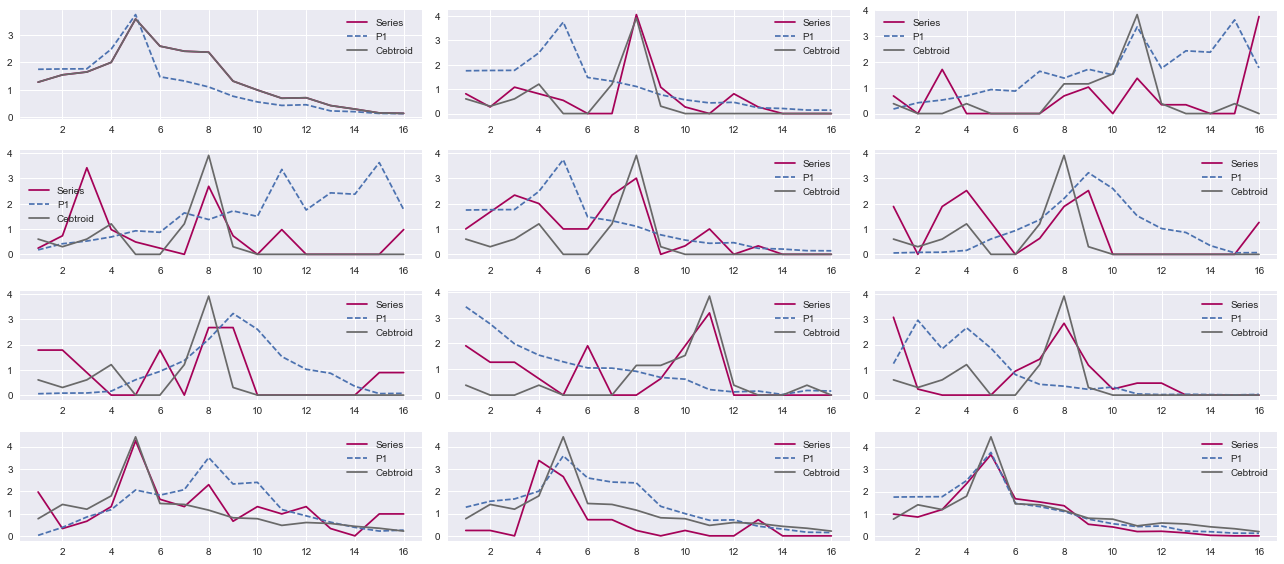

In [318]:
bad = p_series[p_series.PRMSE != p_series.RMSE].nlargest(210,"INDIC")
good = p_series[p_series.CORR>0.8]


disp = p_series.iloc[:,:-4].loc[bad.index[:12]]
display(disp.head(12))




plt.figure(figsize=(18,2 * 4))
i=1;
for index,values in disp.iterrows():
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    series = values[offset:]/values[offset:].std()
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    predicted_series = series_df.loc[guess1]/series_df.loc[guess1].std()
    
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    plt.plot(predicted_series,label="P1",ls='--')
    plt.plot(c_series,label="Cebtroid",c='dimgrey')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
    #plt.plot(p4,label="P4",ls='--')
    
    #show the centroid as well
    
    
    plt.legend(loc=0)
    
    i+=1
    

plt.tight_layout()
plt.show()

# Predict Quantities
### Load features and predictor

In [82]:
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score

features_df = load_file("clf_features",type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))


from sklearn.externals import joblib


features_df.head()
encoded_df = tools.encode(features_df,non_categorical = ["Tprice","Nstore"])

encoded_df.head()

,Pname_Boots,Pname_One In One Pants,Pname_One Internal Pants,Pname_One Pants,Pname_One-Piece Pants,Pname_One-Piece Pants Inside,Pname_Pantyhose,Pname_Short Socks,Pname_Socks,Pname_Wear One Pants,...,Age Group_29-38,Age Group_39-48,Age Group_4-6,Age Group_7-9,Sales Season_Autumn,Sales Season_Spring,Sales Season_Summer,Sales Season_Winter,Tprice,Nstore
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.134078,0.005995
30E000400_2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.106145,0.387290
30E823101_2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.081535
30E823102_2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.082734
30E823103_2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.081535


ImportError: No module named 'classifierModel'

count    105.000000
mean       6.781674
std        9.135681
min        0.559100
25%        1.776116
50%        3.467839
75%        7.104557
max       46.620013
Name: R2, dtype: float64

0.0761904761905


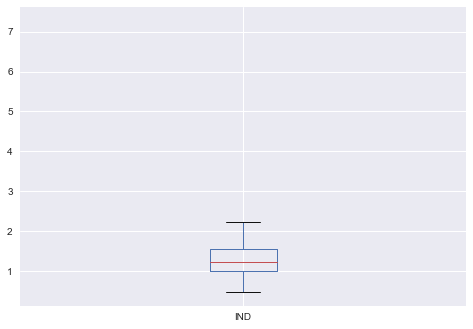

In [83]:
predictor = joblib.load(models_path+'regressor_std.pkl')

disp = p_series.iloc[:,:-4]

R2 = []
RMSE = []
BEST = []
VAR = []
for index,values in disp.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    rmse1 = math.sqrt(MSE(p1,series)/n)
    rmse2 = math.sqrt(MSE(p2,series)/n)
    rmse3 = math.sqrt(MSE(p3,series)/n)
    rmse4 = math.sqrt(MSE(p4,series)/n)
    
    var = math.sqrt(MSE(series,c_series)/n)
    
    VAR.append(var)
    
    r2_1 = tools.MASE(series,series,p1) #r2_score(p1,series,multioutput="uniform_average")
    r2_2 = tools.MASE(series,series,p2)#r2_score(p2,series,multioutput="uniform_average")
    r2_3 = tools.MASE(series,series,p3)#r2_score(p3,series,multioutput="uniform_average")
    r2_4 = tools.MASE(series,series,p4)#r2_score(p4,series,multioutput="uniform_average")
    
    r2 = [r2_1,r2_2,r2_3,r2_4]
    rmse = [rmse1,rmse2,rmse3,rmse4]
    best = 0 #np.argmin(rmse)
    
    BEST.append(best)
    R2.append(r2[best])
    RMSE.append(rmse[best])
    
disp["R2"] = R2
disp["RMSE"] = RMSE
disp["Best"] = BEST
disp["IND"] = np.divide(RMSE,VAR)
display(disp.R2.describe())
disp.IND.plot(kind="box")
print(disp[disp.R2<1].R2.count()/disp.shape[0])
plt.show()

### Display First Prediction

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,11,12,13,14,15,16,R2,RMSE,Best,IND
Product,,,,,,,,,,,,,,,,,,,,,
337015700_2,3,9,1,7,326260000_2,331032200_2,331050900_2,335011700_2,8,337015200_2,...,287.0,190.0,106.0,67.0,50.0,64.0,1.666831,81.863496,0,1.646440
345022900_2,8,9,5,12,337015200_2,331032200_2,335025200_2,331032500_2,1,331050900_2,...,291.0,189.0,268.0,65.0,111.0,121.0,1.725466,53.561348,0,0.603908
331043500_2,2,1,4,9,331051800_2,331050900_2,336012400_2,331032200_2,12,331032500_2,...,29.0,37.0,24.0,16.0,10.0,15.0,1.776116,10.145951,0,1.557001
325033000_2,9,12,5,7,331032200_2,331032500_2,335025200_2,335011700_2,2,331051800_2,...,47.0,32.0,67.0,30.0,20.0,15.0,1.776328,6.946246,0,1.748266
335004401_2,7,12,5,11,335011700_2,331032500_2,335025200_2,335846800_2,1,331050900_2,...,1824.0,1540.0,1853.0,2210.0,1074.0,1163.0,1.798342,386.881799,0,2.074349


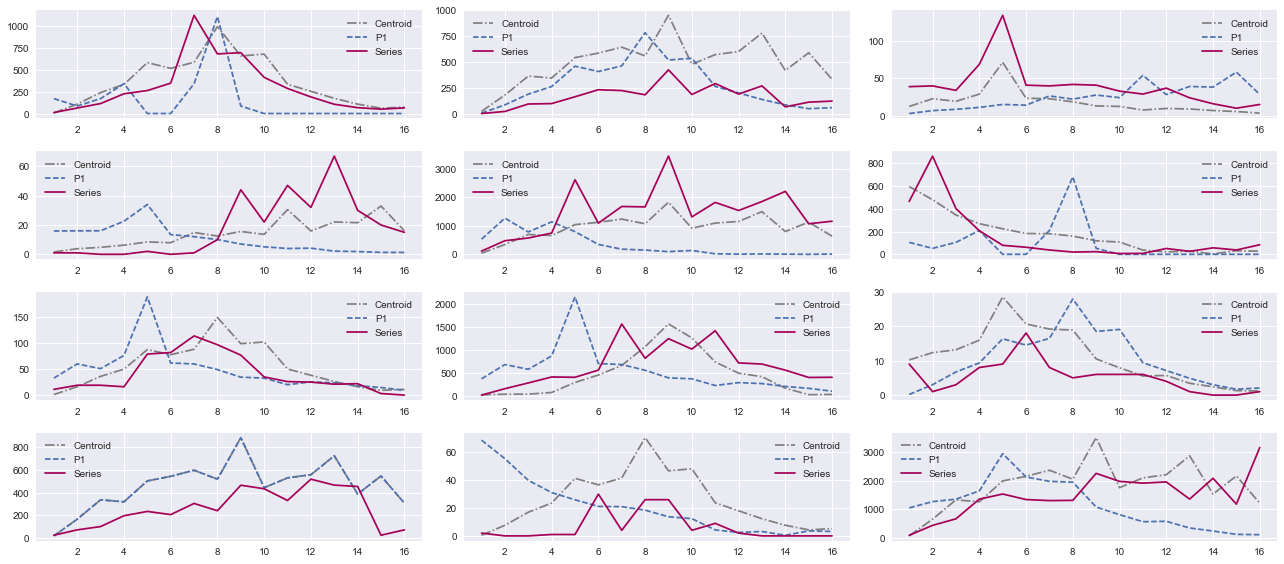

In [94]:
part = 3

display_result = disp[disp.R2>0].nsmallest(disp.shape[0],"R2").iloc[12 * (part-1) : 12 * (part),:-4]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))


i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction

    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    plt.subplot(4,3,i)
    
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    
    best = disp.loc[index].Best
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
    
    plt.plot(p1,label="P1",ls='--')
    
    plt.plot(series,label="Series",c='m')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
#     plt.plot(p4,label="P4",ls='--')



    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()

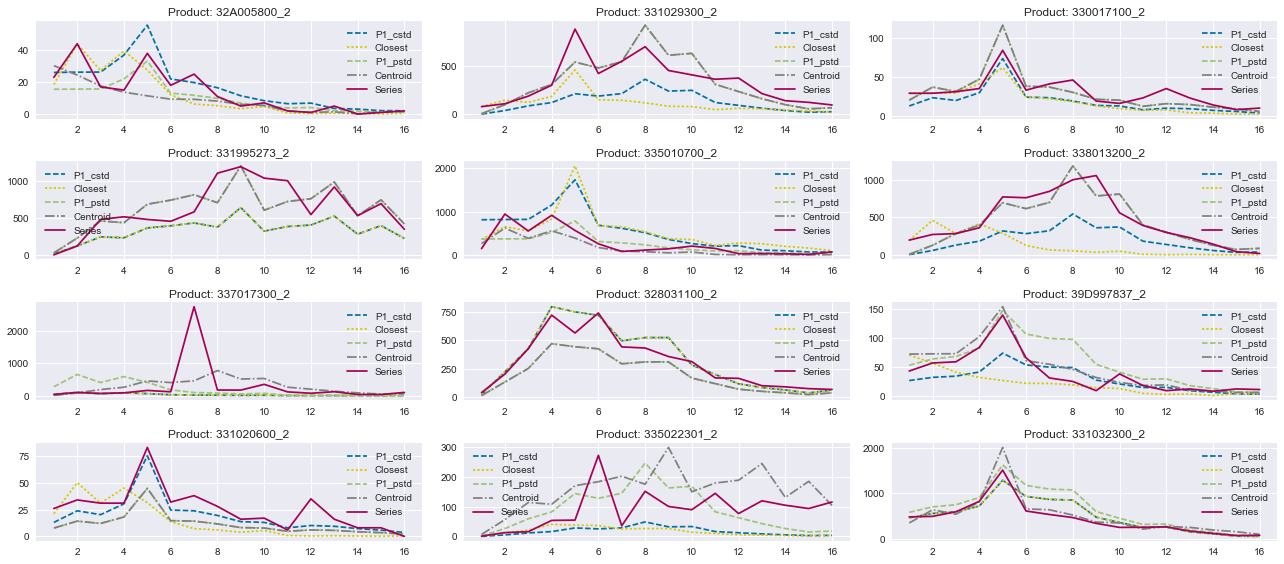

In [90]:
import imp

from visualization import classification_analysis as ca
%aimport visualization.classification_analysis
imp.reload(settings)
imp.reload(visualization.classification_analysis)



ca.predictions_plot(display_result,series_df, standard = False, nearest = True)

plt.show()

### Adjusted Prediction

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,11,12,13,14,15,16,R2,RMSE,Best,IND
Product,,,,,,,,,,,,,,,,,,,,,
331032300_2,5,1,4,8,335025200_2,331050900_2,336012400_2,337015200_2,12,331032500_2,...,252.0,262.0,169.0,118.0,71.0,76.0,1.138069,68.762025,0,1.897247
335022301_2,8,4,7,6,337015200_2,336012400_2,335011700_2,331700300_2,1,331050900_2,...,145.0,77.0,120.0,105.0,94.0,116.0,1.117192,19.239437,0,0.805665
331020600_2,12,10,7,9,331032500_2,338009400_2,335011700_2,331032200_2,12,331032500_2,...,6.0,35.0,16.0,8.0,8.0,0.0,1.005329,4.411613,0,1.000000
39D997837_2,5,9,6,12,335025200_2,331032200_2,331700300_2,331032500_2,9,331032200_2,...,18.0,9.0,12.0,8.0,12.0,11.0,1.002269,7.586317,0,1.970503
328031100_2,4,7,11,3,336012400_2,335011700_2,335846800_2,326260000_2,4,336012400_2,...,168.0,164.0,99.0,89.0,73.0,66.0,0.972846,34.044473,0,1.000000


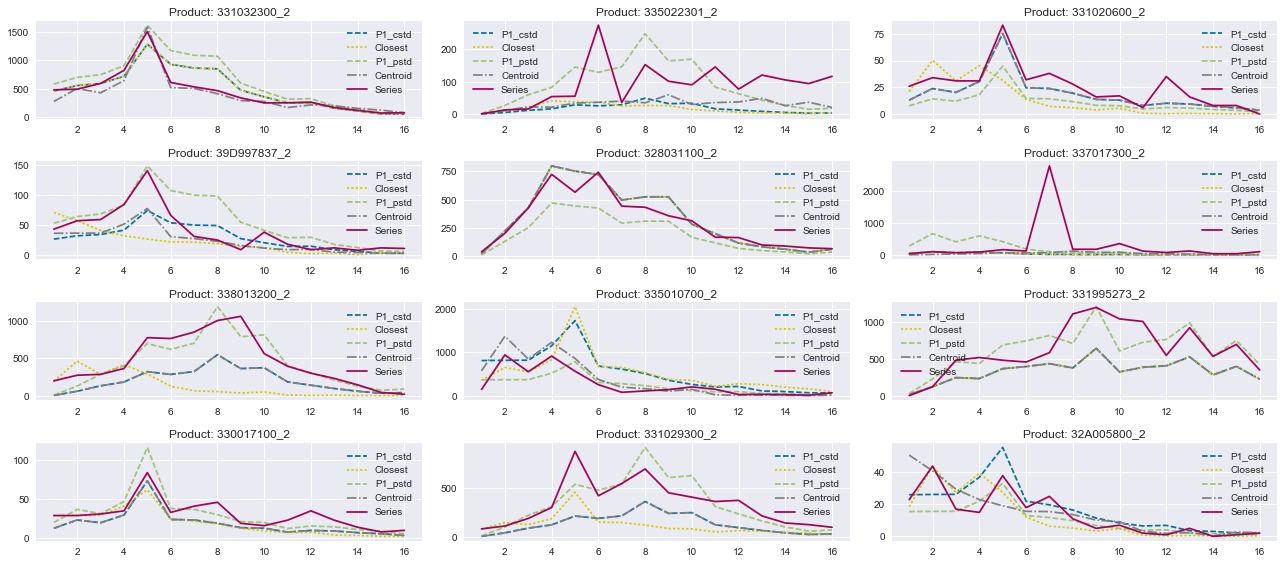

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

display_result = disp[disp.R2>0].nlargest(disp.shape[0],"R2").iloc[-12:,:-4]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))

n_points = 3
i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    
    plt.subplot(4,3,i)
    
    
    first_points = series[:n_points]/series[:n_points].std()
    
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
    
    plt.title("Product: %s" % (index))
        
    #Adjusted
    knn = NearestNeighbors(n_neighbors=1, metric="euclidean")
    knn.fit(p_array.iloc[:,:n_points])  
    closest = knn.kneighbors([first_points], 1, return_distance=False)[0][0]
    
    cstd = (series[:n_points]/p_array.iloc[closest,:n_points]).median()
    
    #multiply by the caluclated std
    p1c = p1 * cstd 
    p1p = p1 * pstd[0]
    c_series *= cstd
    
    
    plt.plot(p1c,label="P1_cstd",ls='--',c='b')
    plt.plot(p_array.iloc[closest]*cstd,label="Closest",c='y',ls=':')
    plt.plot(p1p,label="P1_pstd",ls='--',c='g')
    
    
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    plt.plot(series,label="Series",c='m')

    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()

In [75]:
import imp

from visualization import classification_analysis as ca
%aimport visualization.classification_analysis
imp.reload(settings)
imp.reload(visualization.classification_analysis)

ca.predictions_plot(display_result,series_df, standard = True, nearest = True)

plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').